In [1]:
import pickle
import numpy as np
import itertools as it

from matplotlib import pyplot as plt

In [2]:
def plot_patterns(patterns, titles=None):
    num_patterns = len(patterns)
    
    for p_idx, pattern in enumerate(patterns):
        plt.subplot(1, num_patterns, p_idx+1)
        plt.imshow(pattern, cmap='Greys', interpolation='None')
        
        if titles is not None:
            plt.title(titles[p_idx])
    plt.show()
        
def plot_function(X, Y, title=''):
    plt.plot(X, Y)
    plt.title(title)
    plt.axis([np.min(X), np.max(X), np.min(Y), np.max(Y)])
    plt.title(title)
    plt.grid()
    plt.show()
    
def my_sign(x):
    X_sign = np.array(x)
    X_sign[X_sign >= 0] = 1
    X_sign[X_sign < 0] = -1
    return X_sign.astype(np.int32)
    
def pattern_energy(pattern, weights):
    return -0.5 * pattern.T.dot(weights).dot(pattern)

def flip_n_bits(pattern, n):
    x = pattern.copy()
    order = range(x.shape[0])
    np.random.shuffle(order)
    order = order[:n]
    
    x[order] = -x[order]
    return x

## Hebbian learning

In [3]:
train_pat = np.array([1, -1, 1, -1, 1]).reshape(-1, 1)
test_pat = np.array([1, -1, -1, -1, 1]).reshape(-1, 1)

# single pattern
W = train_pat.dot(train_pat.T)
np.sign(W.dot(test_pat))

print 'Energy (train): ', pattern_energy(train_pat, W)
print 'Energy (test): ', pattern_energy(test_pat, W)

# hebb rule
W = (1. / train_pat.shape[1]) * train_pat.dot(train_pat.T)

print 'Energy (train): ', pattern_energy(train_pat, W)
print 'Energy (test): ', pattern_energy(test_pat, W)

Energy (train):  [[-12.5]]
Energy (test):  [[-4.5]]
Energy (train):  [[-12.5]]
Energy (test):  [[-4.5]]


## Hopfield Network

In [4]:
class HopfieldNet(object):
    def __init__(self):
        self._Ws = None
        
    def train(self, X, remove_self=True):
        self._Ws = (1. / X.shape[1]) * X.dot(X.T)
        
        if remove_self:
            self._Ws -=  np.eye(X.shape[0])
            
    
    def recall(self, pattern, async=False, max_iter=None, verbose=False):
        x = pattern.copy()
        
        if max_iter is None:
            max_iter = int(np.log(self._Ws.shape[1]))
        
        if verbose: 
            print 'Energy (start): ', pattern_energy(x, self._Ws)
        
        for it in xrange(max_iter):
            if async:
                update_order = range(x.shape[0])
                np.random.shuffle(update_order)
                for uit, idx in enumerate(update_order):
                    x[idx] = np.sign(self._Ws[idx].dot(x))
                    
                    if verbose and uit % 100 == 0:
                        print 'Energy (t=%d, u=%d): ' % (it, uit+1), pattern_energy(x, self._Ws)
            else:
                x = my_sign(self._Ws.dot(x)).astype(np.int32)
                if verbose: 
                    print 'Energy (t=%d): ' % it, pattern_energy(x, self._Ws)
        return x

## Digits test

In [5]:
digits_shape = (5, 3)
digits = np.array([[-1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1], 
                   [1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1],
                   [1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1]]).T

digits_test = np.array([[-1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1],
                        [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1],
                        [1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1]]).T

In [6]:
hopfield = HopfieldNet()
hopfield.train(digits)

Energy (clean):  -35.6666666667
Energy (dirty):  -7.66666666667


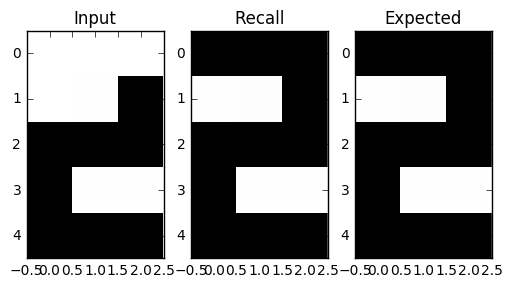

In [7]:
test_idx = 1

print 'Energy (clean): ', pattern_energy(digits[:, test_idx], hopfield._Ws)
print 'Energy (dirty): ', pattern_energy(digits_test[:, test_idx], hopfield._Ws)

img_rec = hopfield.recall(digits_test[:, test_idx], async=True, max_iter=10)

plot_patterns([digits_test[:, test_idx].reshape(digits_shape), 
               img_rec.reshape(digits_shape),
               digits[:, test_idx].reshape(digits_shape)],
              ['Input', 'Recall', 'Expected'])

## KTH Experiments

#### Random Patterns - Convergence nd Attractors

In [8]:
data_shape = (8, 1)
patterns = np.array([[-1, -1, +1, -1, +1, -1, -1, +1], 
                     [-1, -1, -1, -1, -1, +1, -1, -1],
                     [-1, +1, +1, -1, -1, +1, -1, +1]]).T

patterns_dirty = np.array([[-1, -1, +1, -1, +1, -1, -1, +1], # 0 flips input 1
                           [-1, -1, -1, -1, -1, +1, -1, -1], # 0 flips input 2
                           [-1, +1, +1, -1, -1, +1, -1, +1], # 0 flips input 3
                           [+1, -1, +1, -1, +1, -1, -1, +1], # 1 flip  input 1
                           [+1, +1, -1, -1, -1, +1, -1, -1], # 2 flips input 2
                           [+1, +1, +1, -1, +1, +1, -1, +1], # 2 flips input 3
                           [+1, -1, +1, -1, +1, -1, +1, -1], # 3 flips input 1
                           [+1, +1, +1, +1, -1, +1, -1, -1], # 4 flips input 2
                           [+1, +1, +1, +1, +1, +1, +1, -1]]).T # 5 flips input 3

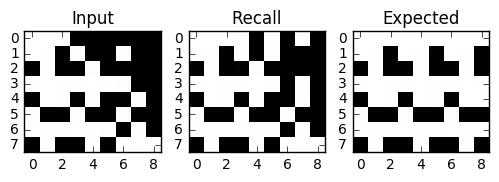

In [9]:
hopfield = HopfieldNet()
hopfield.train(patterns, remove_self=True)
input_rec = np.array([hopfield.recall(pattern) for pattern in patterns.T]).T
test_rec = np.array([hopfield.recall(pattern) for pattern in patterns_dirty.T]).T

plot_patterns([patterns_dirty, 
               test_rec, 
               np.hstack((patterns, patterns,patterns))],
             ['Input', 'Recall', 'Expected'])

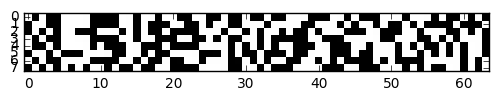

Number of attractors:  64


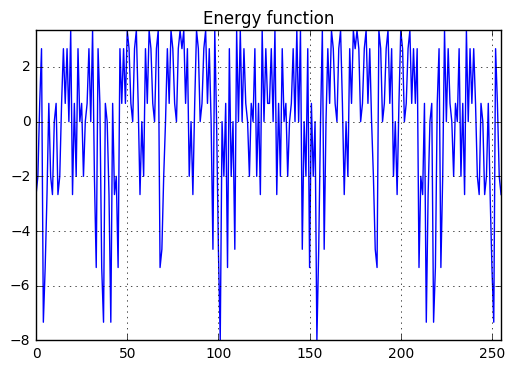

In [10]:
# pattern space
pattern_space = np.array(list(it.product([-1, 1], repeat=8)))

# recall patterns
recalled = np.array([hopfield.recall(pattern, async=False, max_iter=50) for pattern in pattern_space])

# find attractors
attractors = np.array([attractor for attractor in set([tuple(pattern) for pattern in recalled])])
attractor_energies = np.array([pattern_energy(np.array(pattern), hopfield._Ws) for pattern in attractors])
attractor_order = np.argsort(attractor_energies)
plot_patterns([attractors[attractor_order].T])
print 'Number of attractors: ', len(attractors)

# find energies
energies = np.array([(idx, pattern_energy(np.array(pattern), hopfield._Ws)) for idx, pattern in enumerate(pattern_space)])
plot_function(energies[:, 0], energies[:, 1], 'Energy function')

#### Images - Sequential Update

In [11]:
data_shape = (32, 32)

with open('images.p', 'r') as fd:
    data = pickle.load(fd)

data_train = data[:-2]
data_train_mini = data_train[:3]
data_test = data[-2:]

In [12]:
hopfield = HopfieldNet()
hopfield.train(data_train_mini.T)
test_ret = np.array([hopfield.recall(pattern.T, async=False, max_iter=25) for pattern in data_test]).T

Recall of P1


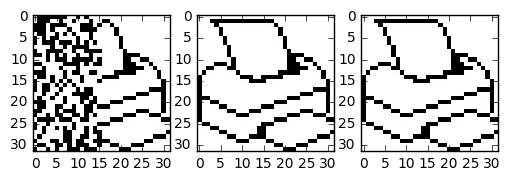

Recall of P2 and P3


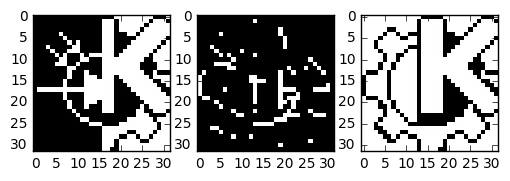

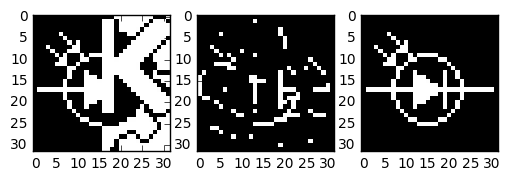

In [13]:
print 'Recall of P1'
plot_patterns([data_test[0].reshape(data_shape).T, 
                   test_ret[:, 0].reshape(data_shape).T, 
                   data_train_mini[0].reshape(data_shape).T])

print 'Recall of P2 and P3'
plot_patterns([data_test[1].reshape(data_shape).T,
                   test_ret[:, 1].reshape(data_shape).T, 
                   data_train_mini[1].reshape(data_shape).T])

plot_patterns([data_test[1].reshape(data_shape).T,
                   test_ret[:, 1].reshape(data_shape).T, 
                   data_train_mini[2].reshape(data_shape).T])